In [85]:
%pip install -r requirements.txt

In [3]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import shutil

from PIL import Image

2024-01-27 17:09:28.453265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 17:09:28.453322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 17:09:28.516045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 17:09:28.647554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 17:09:29.748678: W tensorflow/compiler/tf2

In [4]:
def conv_block(inputs, filters_n):
    n = layers.Conv2D(filters_n, 3, padding="same")(inputs)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    n = layers.Conv2D(filters_n, 3, padding="same")(n)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    return n

def encoder_block(inputs, filters_n):
    x = conv_block(inputs, filters_n)
    p = layers.MaxPool2D(pool_size=(2,2))(x)
    return x, p

def decoder_block(inputs, skip, filters_n):
    x = layers.Conv2DTranspose(filters_n, kernel_size=(2,2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters_n)
    return x


def U_Net(input_shape):
    inputs = layers.Input(shape=input_shape)
    inputs2 = layers.Rescaling(1. /255)(inputs)
    resnet50 = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs2)

    #encode
    s1 = resnet50.get_layer("input_1").output  #512x512
    s2 = resnet50.get_layer("conv1_relu").output  #256x256
    s3 = resnet50.get_layer("conv2_block3_out").output  #128x128
    s4 = resnet50.get_layer("conv3_block4_out").output  #64x64

    #bottleneck
    bottleneck = resnet50.get_layer("conv4_block6_out").output  #32x32

    #decode
    decode1 = decoder_block(bottleneck, s4, 512)
    decode2 = decoder_block(decode1, s3, 256)
    decode3 = decoder_block(decode2, s2, 128)
    decode4 = decoder_block(decode3, s1, 64)
    
    #condense 
    outputs = layers.Conv2D(1,1, padding="same", activation="sigmoid")(decode4)
    model = k.Model(inputs=inputs, outputs=outputs, name="unet")
    return model

model = U_Net((256,256,3))
model.summary()
model.save_weights("seg_model.h5")

2024-01-27 17:09:37.581536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 17:09:37.783722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 17:09:37.783773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 17:09:37.785916: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 17:09:37.785961: I external/local_xla/xla/stream_executor

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['rescaling[0][0]']           
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                               

In [4]:
#classification

def classi(input_shape):
    inputs = layers.Input(shape=input_shape)
    vgg19 = k.applications.VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    x = vgg19(inputs, training=False)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    #classi layers
    for filters in [96, 128, 256]:#, 320]:#, 512]:#, 1024, 2048]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    #output
    x = layers.Dropout(rate=0.1)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="sigmoid")(x)

    output = layers.Dense(7, activation="softmax")(x)

    model = k.Model(inputs=inputs, outputs=output, name="classification")
    return model

classification = classi((256,256,3))
classification.summary()

classification.save_weights("classification.h5")

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 64)          294976    
                                                                 
 activation_8 (Activation)   (None, 8, 8, 64)          0         
                                                                 
 batch_normalization_8 (Bat  (None, 8, 8, 64)          256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 96)          55392     
                                                    

In [7]:
def load_folder_imgs(folder, numimgs, startind, img_shape):
    images = []
    folderfiles = os.listdir(folder)
    for i in range(numimgs):
        if len(folderfiles) > i+startind+1: 
            img = cv2.imread(os.path.join(folder,folderfiles[i+startind]))
            if img is not None:
                images.append(np.array(cv2.resize(img, dsize=img_shape)))
    return [images, i+startind]

datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             )

In [8]:
#For loading classification labels and images.

def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

In [9]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(labels):
    cols = len(labels.columns)-2 #assumes 1 column for image ids
    weights = {}
    for i in range(cols+1):
        weights[i] = 1-np.mean(labels[labels.columns[i+1]].tolist())
    return weights

print(get_weights(pd.read_csv(cls_train_gt)))

from keras import backend as K
def f_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp

def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp

def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn

def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)

def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)


{0: 0.888866699950075, 1: 0.3305042436345482, 2: 0.9486769845232151, 3: 0.9673489765351972, 4: 0.8902646030953569, 5: 0.9885172241637543, 6: 0.9858212680978532}


In [16]:
classification.load_weights('classification.h5') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)
classification.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["binary_accuracy", f_score, precision_score, 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=1.4)] #can adjust to improve accuracy
batch_size=32
spe = 10015//batch_size #steps per epoch
epochs = 80 # set to 1 for debugging purposes
seed = 123

cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

cls_train = r'train/ISIC2018_Task3_Training_Input/'#r"classi/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/" 
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")

for i in range(epochs):
    train_ds, train_gt = load_images_and_labels(cls_train, cls_train_gt, batch_size, (256,256), True)
    val_ds, val_gt = load_images_and_labels(cls_val, cls_val_gt, batch_size, (256,256), True)

    print(f"train_ds len: {len(train_ds)}, train labels len: {len(train_gt)}")
    cls_train_gen = datagen.flow(x=train_ds, y=train_gt, seed=seed, batch_size=batch_size*spe)
    val_train_gen = datagen.flow(x=val_ds, y=val_gt, seed=seed, batch_size=batch_size*spe)
    history = classification.fit(cls_train_gen, steps_per_epoch=spe, 
                                 class_weight=get_weights(pd.read_csv(cls_train_gt)), 
                                 batch_size=batch_size, callbacks=callback_list, verbose=1,
                                 validation_data=(val_train_gen.x, val_train_gen.y), validation_steps=32)
    print(f"--------------- Done epoch {i} -----------------")

classification.save_weights("final_class.h5")



loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32


2024-01-27 16:32:02.232845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inclassification/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-27 16:32:02.761721: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-27 16:32:02.892991: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 16:32:03.057317: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 16:32:05.523822: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fae640501e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-27 16:32:05.523858: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RT

  1/312 [..............................] - ETA: 1:36:12 - loss: 1.1172 - binary_accuracy: 0.8571 - f_score: 0.1587 - precision_score: 0.0645 - auc: 0.3433WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 312 batches). You may need to use the repeat() function when building your dataset.


2024-01-27 16:32:18.655587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:18.655646: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:18.655655: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:18.655659: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:18.655662: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


312/312 [==============================] - 20s 6ms/step - loss: 1.1172 - binary_accuracy: 0.8571 - f_score: 0.1587 - precision_score: 0.0645 - auc: 0.3433 - val_loss: 1.5528 - val_binary_accuracy: 0.8571 - val_f_score: 0.5488 - val_precision_score: 0.2143 - val_auc: 0.8032
--------------- Done epoch 0 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
  1/312 [..............................] - ETA: 2:29 - loss: 1.3089 - binary_accuracy: 0.8661 - f_score: 0.5398 - precision_score: 0.3958 - auc: 0.7744WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `ste

2024-01-27 16:32:21.616636: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


312/312 [==============================] - 2s 4ms/step - loss: 1.3089 - binary_accuracy: 0.8661 - f_score: 0.5398 - precision_score: 0.3958 - auc: 0.7744 - val_loss: 3.3110 - val_binary_accuracy: 0.8571 - val_f_score: 0.1739 - val_precision_score: 0.0702 - val_auc: 0.2232
--------------- Done epoch 1 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 548us/step - loss: 1.2188 - binary_accuracy: 0.8482 - f_score: 0.2370 - precision_score: 0.1205 - auc: 0.4873 - val_loss: 2.1282 - val_binary_accuracy: 0.8571 - val_f_score: 0.5172 - val_precision_score: 0.2414 - val_auc: 0.5456
--------------

2024-01-27 16:32:23.992769: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:23.992808: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:23.992816: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:23.992820: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:23.992823: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 533us/step - loss: 1.0202 - binary_accuracy: 0.8571 - f_score: 0.5918 - precision_score: 0.2479 - auc: 0.8305 - val_loss: 2.3979 - val_binary_accuracy: 0.7635 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.6909
--------------- Done epoch 3 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:25.373744: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:25.373781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:25.373791: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 566us/step - loss: 0.9433 - binary_accuracy: 0.8304 - f_score: 0.5556 - precision_score: 0.2577 - auc: 0.7904 - val_loss: 1.7780 - val_binary_accuracy: 0.8571 - val_f_score: 0.6158 - val_precision_score: 0.2874 - val_auc: 0.7529
--------------- Done epoch 4 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:26.724274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:26.724313: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:26.724321: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:26.724326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:26.724329: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 587us/step - loss: 0.9995 - binary_accuracy: 0.8571 - f_score: 0.6173 - precision_score: 0.2609 - auc: 0.8350 - val_loss: 2.1709 - val_binary_accuracy: 0.8571 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.6954
--------------- Done epoch 5 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:28.114801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:28.114842: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 600us/step - loss: 0.9136 - binary_accuracy: 0.8304 - f_score: 0.5907 - precision_score: 0.2569 - auc: 0.7936 - val_loss: 1.4960 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.7551
--------------- Done epoch 6 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:29.584866: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:29.584903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 538us/step - loss: 0.9145 - binary_accuracy: 0.8616 - f_score: 0.6695 - precision_score: 0.2883 - auc: 0.8627 - val_loss: 2.2372 - val_binary_accuracy: 0.8571 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.6966
--------------- Done epoch 7 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:31.030057: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:31.030100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:31.030112: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 527us/step - loss: 0.8987 - binary_accuracy: 0.8304 - f_score: 0.5417 - precision_score: 0.2321 - auc: 0.7563 - val_loss: 1.5267 - val_binary_accuracy: 0.8571 - val_f_score: 0.6158 - val_precision_score: 0.2874 - val_auc: 0.7521
--------------- Done epoch 8 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:32.423932: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:32.423975: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:32.423983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:32.423987: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:32.423991: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:32:32.570764: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:32:32.570810: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 530us/step - loss: 0.8901 - binary_accuracy: 0.8750 - f_score: 0.6608 - precision_score: 0.3030 - auc: 0.8744 - val_loss: 2.4537 - val_binary_accuracy: 0.8571 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.5940
--------------- Done epoch 9 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:33.763266: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:33.763302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:33.763311: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:32:33.911946: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:32:33.911988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 800376658018237334
2024-01-27 16:32:33.911996: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 529us/step - loss: 0.8605 - binary_accuracy: 0.8304 - f_score: 0.5508 - precision_score: 0.2407 - auc: 0.7483 - val_loss: 1.6281 - val_binary_accuracy: 0.8571 - val_f_score: 0.6158 - val_precision_score: 0.2874 - val_auc: 0.7529
--------------- Done epoch 10 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:35.102923: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:35.102965: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:35.102974: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:35.102978: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:35.102981: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 555us/step - loss: 0.8560 - binary_accuracy: 0.8884 - f_score: 0.6485 - precision_score: 0.2793 - auc: 0.8846 - val_loss: 2.2930 - val_binary_accuracy: 0.7635 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.6925
--------------- Done epoch 11 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:36.415899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:36.415945: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:36.415965: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:36.415973: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:36.415978: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 549us/step - loss: 0.8380 - binary_accuracy: 0.8304 - f_score: 0.6009 - precision_score: 0.2667 - auc: 0.7896 - val_loss: 1.7557 - val_binary_accuracy: 0.8571 - val_f_score: 0.6158 - val_precision_score: 0.2874 - val_auc: 0.7446
--------------- Done epoch 12 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:37.779638: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:37.779676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:32:37.933372: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:32:37.933418: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 800376658018237334
2024-01-27 16:32:37.933427: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 644us/step - loss: 0.8129 - binary_accuracy: 0.8929 - f_score: 0.6485 - precision_score: 0.2793 - auc: 0.9024 - val_loss: 2.2864 - val_binary_accuracy: 0.8571 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.6033


2024-01-27 16:32:39.415123: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:39.415169: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:39.415178: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:39.415183: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:39.415187: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:32:39.596741: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:32:39.596784: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

--------------- Done epoch 13 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 545us/step - loss: 0.7685 - binary_accuracy: 0.8348 - f_score: 0.6432 - precision_score: 0.2743 - auc: 0.8192 - val_loss: 1.9467 - val_binary_accuracy: 0.7143 - val_f_score: 0.6158 - val_precision_score: 0.2874 - val_auc: 0.6662
--------------- Done epoch 14 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:41.080290: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:41.080318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:41.080323: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:41.080327: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:41.080330: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 530us/step - loss: 0.7787 - binary_accuracy: 0.8750 - f_score: 0.6639 - precision_score: 0.2832 - auc: 0.8904 - val_loss: 2.1543 - val_binary_accuracy: 0.8571 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.6954
--------------- Done epoch 15 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:42.382297: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:42.382334: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:42.382342: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:42.382346: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:42.382350: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:32:42.528912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:32:42.528955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 549us/step - loss: 0.7330 - binary_accuracy: 0.8348 - f_score: 0.6639 - precision_score: 0.2832 - auc: 0.8576 - val_loss: 1.7964 - val_binary_accuracy: 0.8571 - val_f_score: 0.6158 - val_precision_score: 0.2874 - val_auc: 0.6667
--------------- Done epoch 16 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:43.687064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:43.687100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 544us/step - loss: 0.7203 - binary_accuracy: 0.8705 - f_score: 0.6612 - precision_score: 0.2807 - auc: 0.9188 - val_loss: 2.3854 - val_binary_accuracy: 0.8571 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.6638
--------------- Done epoch 17 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:45.176109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:45.176146: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:45.176155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 523us/step - loss: 0.7236 - binary_accuracy: 0.8348 - f_score: 0.6596 - precision_score: 0.2897 - auc: 0.8592 - val_loss: 1.9452 - val_binary_accuracy: 0.8571 - val_f_score: 0.5947 - val_precision_score: 0.2432 - val_auc: 0.6575
--------------- Done epoch 18 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:46.621790: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:46.621843: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:46.621852: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:46.621856: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:46.621861: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 527us/step - loss: 0.7425 - binary_accuracy: 0.8795 - f_score: 0.6356 - precision_score: 0.2778 - auc: 0.8816 - val_loss: 2.4466 - val_binary_accuracy: 0.8571 - val_f_score: 0.1437 - val_precision_score: 0.0862 - val_auc: 0.5631
--------------- Done epoch 19 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:47.988258: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 516us/step - loss: 0.7934 - binary_accuracy: 0.8571 - f_score: 0.6360 - precision_score: 0.2900 - auc: 0.8465 - val_loss: 1.8133 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.6100
--------------- Done epoch 20 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:49.406642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:49.406684: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:49.406693: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:49.406697: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:49.406700: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:32:49.549429: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:32:49.549484: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 566us/step - loss: 0.6935 - binary_accuracy: 0.8705 - f_score: 0.6557 - precision_score: 0.2759 - auc: 0.8888 - val_loss: 2.0269 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.6361
--------------- Done epoch 21 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:50.908384: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:50.908436: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 524us/step - loss: 0.7011 - binary_accuracy: 0.8705 - f_score: 0.6769 - precision_score: 0.3069 - auc: 0.8942 - val_loss: 1.9113 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.5710
--------------- Done epoch 22 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:52.323522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:52.323561: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:52.323569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:52.323572: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:52.323576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:32:52.468731: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:32:52.468781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 502us/step - loss: 0.6737 - binary_accuracy: 0.8661 - f_score: 0.6695 - precision_score: 0.2883 - auc: 0.8944 - val_loss: 2.0695 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.5757
--------------- Done epoch 23 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:53.898574: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:53.898615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:53.898623: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:53.898628: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:53.898632: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 515us/step - loss: 0.6589 - binary_accuracy: 0.8884 - f_score: 0.6739 - precision_score: 0.3039 - auc: 0.9094 - val_loss: 2.0389 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.5855
--------------- Done epoch 24 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:55.236957: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:55.236998: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:55.237006: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:55.237010: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 510us/step - loss: 0.6194 - binary_accuracy: 0.8571 - f_score: 0.6926 - precision_score: 0.3107 - auc: 0.8936 - val_loss: 1.9185 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.6670
--------------- Done epoch 25 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:56.681992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:56.682030: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:56.682045: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:56.682050: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:56.682054: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 504us/step - loss: 0.6131 - binary_accuracy: 0.8929 - f_score: 0.7207 - precision_score: 0.3404 - auc: 0.9273 - val_loss: 2.0201 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.5690
--------------- Done epoch 26 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:58.131327: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:58.131366: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:58.131374: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:58.131377: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:58.131381: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:32:58.270465: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:32:58.270508: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 518us/step - loss: 0.6060 - binary_accuracy: 0.8661 - f_score: 0.7080 - precision_score: 0.3265 - auc: 0.9043 - val_loss: 1.8880 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.6667
--------------- Done epoch 27 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:32:59.438079: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:32:59.438116: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:32:59.438124: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:32:59.438128: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:32:59.438132: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 519us/step - loss: 0.5718 - binary_accuracy: 0.9063 - f_score: 0.7207 - precision_score: 0.3404 - auc: 0.9342 - val_loss: 1.9103 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.5690
--------------- Done epoch 28 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:00.831190: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:00.831228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:00.831236: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 517us/step - loss: 0.5730 - binary_accuracy: 0.8884 - f_score: 0.6982 - precision_score: 0.3298 - auc: 0.9303 - val_loss: 1.9985 - val_binary_accuracy: 0.7143 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.5571
--------------- Done epoch 29 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:02.161078: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:02.161121: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:02.161129: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:02.161133: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:02.161136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 592us/step - loss: 0.7301 - binary_accuracy: 0.8527 - f_score: 0.6726 - precision_score: 0.3158 - auc: 0.8753 - val_loss: 2.2273 - val_binary_accuracy: 0.7143 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.5575
--------------- Done epoch 30 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:03.602516: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:03.602558: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:03.602566: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:03.602570: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:03.602574: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 522us/step - loss: 0.6451 - binary_accuracy: 0.8884 - f_score: 0.6550 - precision_score: 0.2970 - auc: 0.9154 - val_loss: 2.1981 - val_binary_accuracy: 0.8571 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5576
--------------- Done epoch 31 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:04.994648: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:04.994688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:04.994697: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:04.994701: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:04.994705: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 519us/step - loss: 0.6224 - binary_accuracy: 0.8839 - f_score: 0.7277 - precision_score: 0.3647 - auc: 0.9080 - val_loss: 2.0961 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.6318
--------------- Done epoch 32 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:06.419280: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:06.419317: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:06.419338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 531us/step - loss: 0.5933 - binary_accuracy: 0.9196 - f_score: 0.7080 - precision_score: 0.3265 - auc: 0.9342 - val_loss: 2.1622 - val_binary_accuracy: 0.8571 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5575
--------------- Done epoch 33 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:07.831413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 531us/step - loss: 0.5941 - binary_accuracy: 0.8839 - f_score: 0.6931 - precision_score: 0.3784 - auc: 0.9151 - val_loss: 2.2751 - val_binary_accuracy: 0.8571 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6437
--------------- Done epoch 34 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:09.177180: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:09.177219: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:09.177227: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:09.177232: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:09.177235: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:09.324680: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:09.324720: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 524us/step - loss: 0.6050 - binary_accuracy: 0.9152 - f_score: 0.7080 - precision_score: 0.3265 - auc: 0.9317 - val_loss: 2.1763 - val_binary_accuracy: 0.8571 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.6102
--------------- Done epoch 35 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:10.548426: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:10.548465: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:10.548475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:10.694262: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:10.694317: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 800376658018237334
2024-01-27 16:33:10.694325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 557us/step - loss: 0.5829 - binary_accuracy: 0.8705 - f_score: 0.7442 - precision_score: 0.3678 - auc: 0.8958 - val_loss: 2.3536 - val_binary_accuracy: 0.8571 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5575
--------------- Done epoch 36 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:11.854173: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:11.854235: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 504us/step - loss: 0.6151 - binary_accuracy: 0.8839 - f_score: 0.7619 - precision_score: 0.3902 - auc: 0.9269 - val_loss: 2.2238 - val_binary_accuracy: 0.8571 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5747
--------------- Done epoch 37 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:13.209430: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:13.209475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:13.209484: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:13.209557: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:13.209574: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 517us/step - loss: 0.6256 - binary_accuracy: 0.8527 - f_score: 0.7078 - precision_score: 0.3407 - auc: 0.8801 - val_loss: 2.2740 - val_binary_accuracy: 0.8571 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5617
--------------- Done epoch 38 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:14.546062: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:14.546101: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:14.546109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:14.546113: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:14.546118: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 540us/step - loss: 0.5570 - binary_accuracy: 0.8973 - f_score: 0.7407 - precision_score: 0.3636 - auc: 0.9403 - val_loss: 2.1812 - val_binary_accuracy: 0.8571 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5735
--------------- Done epoch 39 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:15.907523: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 506us/step - loss: 0.5206 - binary_accuracy: 0.9062 - f_score: 0.7212 - precision_score: 0.3750 - auc: 0.9319 - val_loss: 2.3087 - val_binary_accuracy: 0.8571 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6178
--------------- Done epoch 40 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:17.225179: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:17.225220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:17.225229: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:17.225233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:17.225236: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:17.365353: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:17.365397: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 510us/step - loss: 0.4652 - binary_accuracy: 0.9152 - f_score: 0.7416 - precision_score: 0.3827 - auc: 0.9583 - val_loss: 2.2050 - val_binary_accuracy: 0.8571 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5741
--------------- Done epoch 41 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:18.558250: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:18.558288: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:18.558297: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:18.699524: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688
2024-01-27 16:33:18.699636: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 500us/step - loss: 0.4913 - binary_accuracy: 0.9018 - f_score: 0.7960 - precision_score: 0.4384 - auc: 0.9504 - val_loss: 2.4772 - val_binary_accuracy: 0.8571 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6609
--------------- Done epoch 42 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:19.912947: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:20.050862: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:20.050905: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 545us/step - loss: 0.5977 - binary_accuracy: 0.8661 - f_score: 0.7656 - precision_score: 0.3951 - auc: 0.9016 - val_loss: 2.2123 - val_binary_accuracy: 0.8571 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6609
--------------- Done epoch 43 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:21.212270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:21.212308: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:21.212317: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:21.212322: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:21.212326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 524us/step - loss: 0.7440 - binary_accuracy: 0.8482 - f_score: 0.6635 - precision_score: 0.3373 - auc: 0.8577 - val_loss: 1.7391 - val_binary_accuracy: 0.8571 - val_f_score: 0.6034 - val_precision_score: 0.2414 - val_auc: 0.6609
--------------- Done epoch 44 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:22.541337: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:22.541378: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:22.541386: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:22.541391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:22.541395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:22.687215: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:22.687258: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 554us/step - loss: 0.5888 - binary_accuracy: 0.8839 - f_score: 0.7452 - precision_score: 0.3875 - auc: 0.9152 - val_loss: 2.2443 - val_binary_accuracy: 0.7438 - val_f_score: 0.4615 - val_precision_score: 0.2278 - val_auc: 0.6576
--------------- Done epoch 45 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:24.187074: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:24.187116: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:24.187124: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:24.187128: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:24.187132: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 539us/step - loss: 0.5454 - binary_accuracy: 0.9152 - f_score: 0.7207 - precision_score: 0.3404 - auc: 0.9469 - val_loss: 2.1229 - val_binary_accuracy: 0.7438 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5747
--------------- Done epoch 46 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:25.703335: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:25.703377: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:25.703385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:25.703390: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:25.703393: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 503us/step - loss: 0.4920 - binary_accuracy: 0.8973 - f_score: 0.7614 - precision_score: 0.4348 - auc: 0.9336 - val_loss: 2.2137 - val_binary_accuracy: 0.7438 - val_f_score: 0.5025 - val_precision_score: 0.2410 - val_auc: 0.6605
--------------- Done epoch 47 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:27.063839: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:27.063879: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:27.063888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:27.063892: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:27.063896: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:27.202758: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 525us/step - loss: 0.4560 - binary_accuracy: 0.9241 - f_score: 0.7843 - precision_score: 0.4211 - auc: 0.9673 - val_loss: 2.2197 - val_binary_accuracy: 0.7438 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5747
--------------- Done epoch 48 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:28.394219: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:28.394256: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:28.394264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:28.394268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:28.394272: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 503us/step - loss: 0.4591 - binary_accuracy: 0.9018 - f_score: 0.7463 - precision_score: 0.4110 - auc: 0.9377 - val_loss: 2.0728 - val_binary_accuracy: 0.7438 - val_f_score: 0.5665 - val_precision_score: 0.2644 - val_auc: 0.6609
--------------- Done epoch 49 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:29.754217: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:29.754255: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:29.754263: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:29.754267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:29.754271: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 508us/step - loss: 0.4778 - binary_accuracy: 0.9196 - f_score: 0.7416 - precision_score: 0.3827 - auc: 0.9637 - val_loss: 2.3565 - val_binary_accuracy: 0.7438 - val_f_score: 0.1970 - val_precision_score: 0.0920 - val_auc: 0.5747
--------------- Done epoch 50 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:31.182474: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:31.182514: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:31.182522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:31.182527: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:31.323142: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:31.323183: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 800376658018237334
2024-01-27 16:33:31.323191: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv ite

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 508us/step - loss: 0.5464 - binary_accuracy: 0.8705 - f_score: 0.7246 - precision_score: 0.3797 - auc: 0.9036 - val_loss: 1.9549 - val_binary_accuracy: 0.7438 - val_f_score: 0.5665 - val_precision_score: 0.2644 - val_auc: 0.6609
--------------- Done epoch 51 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:32.551579: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:32.551618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:32.551626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:32.551631: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:32.551634: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 509us/step - loss: 0.6107 - binary_accuracy: 0.9062 - f_score: 0.6938 - precision_score: 0.3580 - auc: 0.9320 - val_loss: 2.3563 - val_binary_accuracy: 0.7438 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.5752
--------------- Done epoch 52 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:33.911567: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:33.911608: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:33.911616: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:33.911620: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:33.911624: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:34.052633: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:34.052677: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 513us/step - loss: 0.6693 - binary_accuracy: 0.8661 - f_score: 0.6522 - precision_score: 0.3418 - auc: 0.8779 - val_loss: 2.0496 - val_binary_accuracy: 0.7438 - val_f_score: 0.5665 - val_precision_score: 0.2644 - val_auc: 0.7759
--------------- Done epoch 53 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:35.459395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:35.459436: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:35.459444: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:35.459448: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:35.459451: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 538us/step - loss: 0.5619 - binary_accuracy: 0.9062 - f_score: 0.7381 - precision_score: 0.3780 - auc: 0.9364 - val_loss: 2.4114 - val_binary_accuracy: 0.7438 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6626
--------------- Done epoch 54 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:36.917499: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:36.917540: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:36.917549: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:37.066063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:37.066122: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 800376658018237334
2024-01-27 16:33:37.066131: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 518us/step - loss: 0.4873 - binary_accuracy: 0.9062 - f_score: 0.7246 - precision_score: 0.3797 - auc: 0.9386 - val_loss: 2.3206 - val_binary_accuracy: 0.7438 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6609
--------------- Done epoch 55 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:38.316252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:38.316296: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:38.316304: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:38.316308: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 506us/step - loss: 0.4388 - binary_accuracy: 0.9330 - f_score: 0.7477 - precision_score: 0.3721 - auc: 0.9648 - val_loss: 2.2690 - val_binary_accuracy: 0.7438 - val_f_score: 0.5665 - val_precision_score: 0.2644 - val_auc: 0.6609
--------------- Done epoch 56 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:39.752050: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:39.752093: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:39.752101: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:39.752105: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:39.752109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 536us/step - loss: 0.4686 - binary_accuracy: 0.9063 - f_score: 0.7732 - precision_score: 0.4545 - auc: 0.9383 - val_loss: 2.3480 - val_binary_accuracy: 0.7438 - val_f_score: 0.5665 - val_precision_score: 0.2644 - val_auc: 0.6609
--------------- Done epoch 57 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:41.277895: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:41.277933: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:41.277944: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:41.427109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:41.427153: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 800376658018237334
2024-01-27 16:33:41.427161: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 509us/step - loss: 0.4641 - binary_accuracy: 0.9241 - f_score: 0.7692 - precision_score: 0.4000 - auc: 0.9631 - val_loss: 2.4487 - val_binary_accuracy: 0.7438 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6609
--------------- Done epoch 58 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:42.728415: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:42.728458: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:42.728466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:42.728470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:42.728474: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:42.868883: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:42.868945: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 514us/step - loss: 0.4848 - binary_accuracy: 0.9062 - f_score: 0.7181 - precision_score: 0.4500 - auc: 0.9290 - val_loss: 2.4779 - val_binary_accuracy: 0.7438 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6604
--------------- Done epoch 59 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:44.144500: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:44.144542: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:44.144551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:44.144555: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:44.144558: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 502us/step - loss: 0.4044 - binary_accuracy: 0.9241 - f_score: 0.7656 - precision_score: 0.3951 - auc: 0.9653 - val_loss: 2.2567 - val_binary_accuracy: 0.7438 - val_f_score: 0.5665 - val_precision_score: 0.2644 - val_auc: 0.7184
--------------- Done epoch 60 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:45.440492: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:45.440535: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:45.440544: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 517us/step - loss: 0.3879 - binary_accuracy: 0.9241 - f_score: 0.8040 - precision_score: 0.4507 - auc: 0.9644 - val_loss: 2.3652 - val_binary_accuracy: 0.7438 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6609
--------------- Done epoch 61 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:46.810921: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:46.810964: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:46.810972: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:46.810976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:46.810979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 520us/step - loss: 0.3886 - binary_accuracy: 0.9286 - f_score: 0.7960 - precision_score: 0.4384 - auc: 0.9744 - val_loss: 2.4914 - val_binary_accuracy: 0.7438 - val_f_score: 0.0893 - val_precision_score: 0.0577 - val_auc: 0.6624
--------------- Done epoch 62 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:48.211671: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:48.211709: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:48.211717: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:48.211721: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:48.211725: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 505us/step - loss: 0.5275 - binary_accuracy: 0.8929 - f_score: 0.7214 - precision_score: 0.3973 - auc: 0.9214 - val_loss: 2.3417 - val_binary_accuracy: 0.7438 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6609
--------------- Done epoch 63 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:49.712645: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:49.712684: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:49.712691: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:49.712696: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:49.712699: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 513us/step - loss: 0.5431 - binary_accuracy: 0.8929 - f_score: 0.7692 - precision_score: 0.4000 - auc: 0.9243 - val_loss: 2.3373 - val_binary_accuracy: 0.7438 - val_f_score: 0.1034 - val_precision_score: 0.1034 - val_auc: 0.6609
--------------- Done epoch 64 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:51.030956: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:51.030999: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:51.031007: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:51.031011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:51.031014: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:51.173058: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:51.173107: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 525us/step - loss: 0.4173 - binary_accuracy: 0.9330 - f_score: 0.7908 - precision_score: 0.4559 - auc: 0.9604 - val_loss: 2.3964 - val_binary_accuracy: 0.7438 - val_f_score: 0.0862 - val_precision_score: 0.0517 - val_auc: 0.6609
--------------- Done epoch 65 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:52.402577: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:52.402615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:52.402623: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:52.402628: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:52.402632: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:52.547847: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:52.547889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 510us/step - loss: 0.3848 - binary_accuracy: 0.9330 - f_score: 0.7729 - precision_score: 0.4051 - auc: 0.9762 - val_loss: 2.1661 - val_binary_accuracy: 0.7438 - val_f_score: 0.6319 - val_precision_score: 0.3485 - val_auc: 0.7755
--------------- Done epoch 66 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:53.771756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:53.771797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:53.771805: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:53.771809: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 510us/step - loss: 0.3802 - binary_accuracy: 0.9196 - f_score: 0.8031 - precision_score: 0.4769 - auc: 0.9647 - val_loss: 2.2704 - val_binary_accuracy: 0.7438 - val_f_score: 0.6609 - val_precision_score: 0.3966 - val_auc: 0.7759
--------------- Done epoch 67 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:55.090462: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:55.090506: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:55.090515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:55.231488: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:55.231551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 800376658018237334
2024-01-27 16:33:55.231560: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 502us/step - loss: 0.3203 - binary_accuracy: 0.9554 - f_score: 0.8081 - precision_score: 0.4571 - auc: 0.9861 - val_loss: 2.3265 - val_binary_accuracy: 0.7438 - val_f_score: 0.1034 - val_precision_score: 0.1034 - val_auc: 0.7759
--------------- Done epoch 68 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:56.412103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:56.412143: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:56.412151: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:56.412156: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 537us/step - loss: 0.3115 - binary_accuracy: 0.9464 - f_score: 0.8245 - precision_score: 0.5167 - auc: 0.9793 - val_loss: 2.0615 - val_binary_accuracy: 0.7438 - val_f_score: 0.6609 - val_precision_score: 0.3966 - val_auc: 0.7529
--------------- Done epoch 69 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:57.739903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:57.739945: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:57.739953: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:57.739957: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:57.739960: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:33:57.889566: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:33:57.889609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 527us/step - loss: 0.3953 - binary_accuracy: 0.8973 - f_score: 0.7882 - precision_score: 0.4267 - auc: 0.9515 - val_loss: 2.2788 - val_binary_accuracy: 0.7438 - val_f_score: 0.6609 - val_precision_score: 0.3966 - val_auc: 0.7759
--------------- Done epoch 70 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:33:59.191740: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:33:59.191781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:33:59.191789: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:33:59.191793: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:33:59.191797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 521us/step - loss: 0.4101 - binary_accuracy: 0.9062 - f_score: 0.7979 - precision_score: 0.5000 - auc: 0.9548 - val_loss: 2.5035 - val_binary_accuracy: 0.7438 - val_f_score: 0.1034 - val_precision_score: 0.1034 - val_auc: 0.7759
--------------- Done epoch 71 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:34:00.499551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:34:00.499595: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:34:00.499603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:00.499607: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:34:00.499612: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:34:00.643502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 510us/step - loss: 0.3500 - binary_accuracy: 0.9420 - f_score: 0.8163 - precision_score: 0.4706 - auc: 0.9717 - val_loss: 2.3720 - val_binary_accuracy: 0.7438 - val_f_score: 0.2922 - val_precision_score: 0.2368 - val_auc: 0.7744
--------------- Done epoch 72 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:34:01.800781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:01.800832: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 512us/step - loss: 0.3167 - binary_accuracy: 0.9375 - f_score: 0.8115 - precision_score: 0.4921 - auc: 0.9734 - val_loss: 2.3256 - val_binary_accuracy: 0.7438 - val_f_score: 0.6609 - val_precision_score: 0.3966 - val_auc: 0.7759
--------------- Done epoch 73 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:34:03.120868: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:03.120907: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224
2024-01-27 16:34:03.263235: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 949867598500275867
2024-01-27 16:34:03.263279: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 800376658018237334
2024-01-27 16:34:03.263288: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14629742632106480688


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 503us/step - loss: 0.3313 - binary_accuracy: 0.9509 - f_score: 0.8073 - precision_score: 0.4844 - auc: 0.9784 - val_loss: 2.3231 - val_binary_accuracy: 0.7438 - val_f_score: 0.6609 - val_precision_score: 0.3966 - val_auc: 0.7644


2024-01-27 16:34:04.511283: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:34:04.511324: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:34:04.511332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:04.511336: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:34:04.511339: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


--------------- Done epoch 74 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 510us/step - loss: 0.3953 - binary_accuracy: 0.9062 - f_score: 0.7853 - precision_score: 0.4762 - auc: 0.9505 - val_loss: 2.1686 - val_binary_accuracy: 0.7438 - val_f_score: 0.6609 - val_precision_score: 0.3966 - val_auc: 0.7769
--------------- Done epoch 75 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:34:06.405896: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:06.405928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:34:06.405937: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 504us/step - loss: 0.4488 - binary_accuracy: 0.9375 - f_score: 0.7614 - precision_score: 0.4348 - auc: 0.9588 - val_loss: 2.5072 - val_binary_accuracy: 0.7438 - val_f_score: 0.1034 - val_precision_score: 0.1034 - val_auc: 0.7529
--------------- Done epoch 76 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:34:07.697118: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:34:07.697158: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:34:07.697166: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:07.697171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:34:07.697174: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 507us/step - loss: 0.6233 - binary_accuracy: 0.8973 - f_score: 0.7246 - precision_score: 0.3797 - auc: 0.9241 - val_loss: 2.3346 - val_binary_accuracy: 0.7438 - val_f_score: 0.6609 - val_precision_score: 0.3966 - val_auc: 0.7759
--------------- Done epoch 77 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:34:09.039209: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:34:09.039252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:34:09.039260: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:09.039264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:34:09.039268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 604us/step - loss: 0.5079 - binary_accuracy: 0.8839 - f_score: 0.7250 - precision_score: 0.4028 - auc: 0.9276 - val_loss: 2.3540 - val_binary_accuracy: 0.7438 - val_f_score: 0.6609 - val_precision_score: 0.3966 - val_auc: 0.7529
--------------- Done epoch 78 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-27 16:34:10.388106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:34:10.388152: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:10.388161: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:34:10.388165: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
312/312 [==============================] - 1s 505us/step - loss: 0.3397 - binary_accuracy: 0.9464 - f_score: 0.8040 - precision_score: 0.4507 - auc: 0.9797 - val_loss: 2.4950 - val_binary_accuracy: 0.7438 - val_f_score: 0.1034 - val_precision_score: 0.1034 - val_auc: 0.7549
--------------- Done epoch 79 -----------------


2024-01-27 16:34:11.732559: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1816547674124122375
2024-01-27 16:34:11.732604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7453977640859805868
2024-01-27 16:34:11.732613: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10884394083048784188
2024-01-27 16:34:11.732618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252024012712358584
2024-01-27 16:34:11.732622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17734629638482231224


In [11]:
model.load_weights('seg_model.h5') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=8
spe = 32 #steps per epoch
currentindx1=0
currentindy1=0
currentindx2=0
currentindy2=0
epochs = 80

seg_X_path = "train_seg/ISIC2018_Task1-2_Training_Input"
seg_y_path = "train_seg_gt/ISIC2018_Task1_Training_GroundTruth"

seg_val_X_path = "validation_seg/ISIC2018_Task1-2_Validation_Input"
seg_val_y_path = "validation_seg_gt/ISIC2018_Task1_Validation_GroundTruth"

for i in range(epochs+1):
    currentindy1=currentindx1
    currentindy2=currentindy2
    seg_x = load_folder_imgs(seg_X_path, batchsize, currentindx1, (256,256))
    seg_y = load_folder_imgs(seg_y_path, batchsize, currentindy1, (256,256))
    seg_val_x = load_folder_imgs(seg_val_X_path, batchsize, currentindx2, (256,256))
    seg_val_y = load_folder_imgs(seg_val_y_path, batchsize, currentindy2, (256,256))

    train_gt_X = seg_x[0] 
    train_gt_y = seg_y[0]
    currentinx1 = seg_x[1]
    currentiny1 = seg_y[1]

    val_train_gt_X = seg_val_x[0] 
    val_train_gt_y = seg_val_y[0]
    currentinx2 = seg_val_x[1]
    currentiny2 = seg_val_y[1]
    
    train_gt_X = [x//255 for x in train_gt_X]
    train_gt_y = [x//255 for x in train_gt_y]
    train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in train_gt_y]

    val_train_gt_X = [x//255 for x in val_train_gt_X]
    val_train_gt_y = [x//255 for x in val_train_gt_y]
    val_train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in val_train_gt_y]

    print(np.array(train_gt_y).shape)
    train_gt_X = tf.stack(train_gt_X) 
    train_gt_y = tf.stack(train_gt_y)

    val_train_gt_X = tf.stack(val_train_gt_X) 
    val_train_gt_y = tf.stack(val_train_gt_y)

    train_generator = datagen.flow(x=train_gt_X, y=train_gt_y, batch_size=batchsize)
    val_generator = datagen.flow(x=val_train_gt_X, y=val_train_gt_y, batch_size=batchsize)
    model.fit(train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1, validation_data=val_generator)
    print(f"--------------- Done epoch {i} -----------------")

model.save_weights("final_seg_res50.h5")



(8, 256, 256)


2024-01-27 17:31:40.649930: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-27 17:31:40.930679: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 17:31:41.563604: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 17:31:46.855221: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f85081cbc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-27 17:31:46.855262: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1706405506.899941   92210 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 25s 35ms/step - loss: 0.8530 - binary_accuracy: 0.4397 - mean_squared_error: 0.2970 - auc: 0.4697 - val_loss: 0.6382 - val_binary_accuracy: 0.7129 - val_mean_squared_error: 0.2229 - val_auc: 0.4894
--------------- Done epoch 0 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 8ms/step - loss: 0.6554 - binary_accuracy: 0.5103 - mean_squared_error: 0.2345 - auc: 0.6949 - val_loss: 0.6414 - val_binary_accuracy: 0.7145 - val_mean_squared_error: 0.2244 - val_auc: 0.4902
--------------- Done epoch 1 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 8ms/step - loss: 0.5851 - binary_accuracy: 0.7005 - mean_squared_error: 0.1981 - auc: 0.6804 - val_loss: 0.6418 - val_binary_accuracy: 0.7158 - val_mean_squared_error: 0.2246 - val_auc: 0.4910
--------------- Done epoch 2 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 7ms/step - loss: 0.5323 - binary_accuracy: 0.7814 - mean_squ

In [12]:
#individual testing

pred_folder = "validation/ISIC2018_Task3_Validation_Input/"
pred_image = "ISIC_0034459"
labels_path = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
classification.load_weights("final_class.h5") # make sure to run only after training the classification model

pred_label_df = pd.read_csv(labels_path)
pred_label = pred_label_df.loc[pred_label_df['image']==pred_image]

test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image) + ".jpg"))
plt.imshow(test_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(test_image, (256,256))
print(pred_image.shape)
pred = classification.predict(pred_image[None,])
pred_label = np.argmax(classification.predict(pred_image[None,]), axis=-1)

print(f"True Label: {pred_label}")
print(f"Prediction Scores: {pred}")
print(f"Predicted Label: {pred_label}")

plt.imshow(pred, interpolation='nearest')
plt.show() 


NameError: name 'classification' is not defined

(2848, 4288, 3)


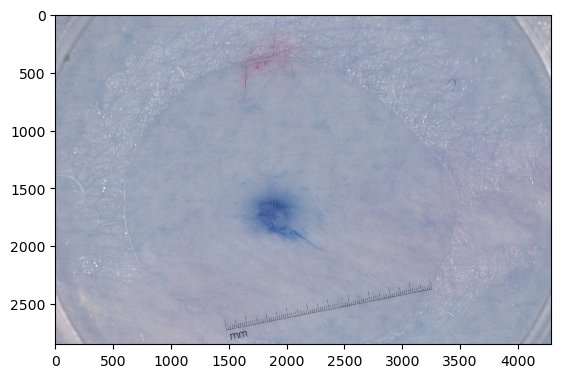

(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
(1, 256, 256, 1)
(1, 256, 256)


TypeError: Invalid shape (1, 256, 256) for image data

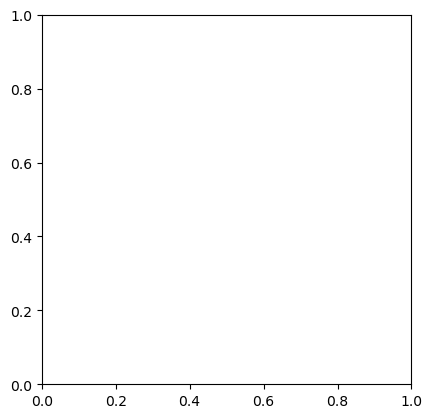

In [27]:
pred_folder = "validation_seg/ISIC2018_Task1-2_Validation_Input"

pred_image = np.array(cv2.imread(os.path.join(pred_folder,"ISIC_0012255.jpg"))) #change to another image if you wish
print(pred_image.shape)

plt.imshow(pred_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(pred_image, (256,256))
pred_image=pred_image//255
pred_image = pred_image.reshape((1,256,256,3))
pred = model.predict(pred_image)
x = pred[0,:, :, :]
print(x.shape)
plt.imshow(x, interpolation='nearest')
plt.show() 